# Assignment 4 – Airbnb Price Prediction Across Market Tiers  

This project implements Assignment 4 on tiered Airbnb price modeling using:

✔ XGBoost  
✔ Neural networks (two architectures)  
✔ SHAP explainability  
✔ Cross-tier generalization tests  

We study how pricing models behave in three market sizes:

- **Big Cities:** New York, Los Angeles, San Francisco, Chicago  
- **Medium Cities:** Austin, Seattle, Denver, Portland  
- **Small Cities:** Asheville, Santa Cruz, Salem, Columbus  

This notebook:

1. Cleans & engineers Airbnb data  
2. Builds per-city price models  
3. Evaluates tier-level composite models  
4. Tests how neural networks generalize across markets  
5. Explains predictions with SHAP  

This work follows the assignment instructions and produces interpretable insights.


In [1]:
!pip install xgboost shap tensorflow keras


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option("display.max_columns", 200)
sns.set()


##  Data Acquisition & Formatting

Data is sourced from **Inside Airbnb – Get the Data**, using **“Detailed Listings Data (listings.csv.gz)”** for each city.

For each city:

1. Download `listings.csv.gz`  
2. Extract to `listings.csv`  
3. Rename using the convention:

```text
new_york_city_listings.csv
los_angeles_listings.csv
san_francisco_listings.csv
chicago_listings.csv
austin_listings.csv
seattle_listings.csv
denver_listings.csv
portland_listings.csv
asheville_listings.csv
santa_cruz_listings.csv
salem_listings.csv
columbus_listings.csv


## City Mapping, Core Features & Preprocessing Pipeline

We now define:

- A mapping from each of the 12 cities to one of the 3 tiers  
- A loader that reads `<city>_listings.csv` and tags each row with its city and tier  
- The **base numeric features** required in the assignment (accommodations, review scores, nights, etc.)

###  Data Cleaning Rules

Inside Airbnb’s `price` column includes `$` signs and commas, so we:

- strip `$` and `,`  
- convert to numeric  

Bathroom information appears as `bathrooms_text` (e.g., "1.5 shared baths") or `bathrooms`.  
We normalize this into a numeric `bathrooms_text` field.

###  Feature Engineering (Required 4+ extra features)

We engineer the following additional features:

1. **amenities_count** – number of amenities listed  
2. **avg_review_score** – mean of review sub-scores  
3. **price_per_person** – price per accommodated guest  
4. **is_entire_home** – binary flag for entire home/apt listings  

###  Preprocessing Function

The preprocessing function:

- drops rows with missing `price`  
- selects all base + engineered features  
- imputes missing values with medians  
- returns feature matrix `X` and target `y`  

This pipeline is reused for every city and every tier.


In [3]:

CITY_TIER_MAP = {
    "new_york_city": "big",
    "los_angeles": "big",
    "san_francisco": "big",
    "chicago": "big",

    "austin": "medium",
    "seattle": "medium",
    "denver": "medium",
    "portland": "medium",

    "asheville": "small",
    "santa_cruz": "small",
    "salem": "small",
    "columbus": "small",
}

ALL_CITIES = list(CITY_TIER_MAP.keys())

# ---------- File loader ----------
def load_city_listings(city_key, base_path="."):
    """
    Load detailed listings data for a given city.

    Expects filenames like: austin_listings.csv, new_york_city_listings.csv, etc.
    """
    if city_key not in CITY_TIER_MAP:
        raise ValueError(f"Unknown city_key: {city_key}")

    tier = CITY_TIER_MAP[city_key]
    filename = f"{city_key}_listings.csv"
    filepath = os.path.join(base_path, filename)

    if not os.path.exists(filepath):
        raise FileNotFoundError(
            f"File not found: {filepath}. "
            "Make sure you uploaded the detailed listings CSV "
            "(listings.csv.gz → extracted → renamed)."
        )

    df = pd.read_csv(filepath)
    df["city_key"] = city_key
    df["tier"] = tier
    return df


# ---------- Required base numeric features ----------
BASE_NUMERIC_FEATURES = [
    "accommodates",
    "bedrooms",
    "beds",
    "bathrooms_text",  # will be converted to numeric
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "number_of_reviews",
    "availability_365",
    "minimum_nights",
    "maximum_nights",
]


# ---------- Step 1: clean raw city df ----------
def clean_raw_city_df(df):
    """
    Clean raw Inside Airbnb listings df:
    - ensure price is numeric
    - parse bathrooms_text (or bathrooms) into a numeric bathrooms_text column
    - ensure all base feature columns exist
    - coerce all base numeric features to numeric dtype
    """
    df = df.copy()

    # --- Clean price ---
    if "price" in df.columns:
        df["price"] = (
            df["price"]
            .astype(str)
            .str.replace(r"[\$,]", "", regex=True)
        )
        df["price"] = pd.to_numeric(df["price"], errors="coerce")
    else:
        raise ValueError("No 'price' column found in this dataset.")

    # --- Parse bathrooms_text to numeric ---
    if "bathrooms_text" in df.columns:
        def parse_bathrooms(text):
            try:
                return float(str(text).split()[0])  # "1 bath", "1.5 shared" → 1 or 1.5
            except:
                return np.nan
        df["bathrooms_text"] = df["bathrooms_text"].apply(parse_bathrooms)
    elif "bathrooms" in df.columns:
        df["bathrooms_text"] = pd.to_numeric(df["bathrooms"], errors="coerce")
    else:
        df["bathrooms_text"] = np.nan

    # --- Ensure all base numeric feature columns exist ---
    for col in BASE_NUMERIC_FEATURES:
        if col not in df.columns:
            df[col] = np.nan  # create, will be numeric

    # --- Coerce all base numeric features to numeric dtype ---
    for col in BASE_NUMERIC_FEATURES:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    return df


# ---------- Step 2: feature engineering ----------
def engineer_features(df):
    """
    Add engineered features required by the assignment:
    - amenities_count
    - avg_review_score
    - price_per_person
    - is_entire_home
    """
    df = df.copy()

    # 1) amenities_count
    if "amenities" in df.columns:
        df["amenities_count"] = (
            df["amenities"]
            .fillna("")
            .apply(lambda x: len(str(x).strip("[]").split(",")) if str(x).strip() != "" else 0)
        )
    else:
        df["amenities_count"] = 0

    # 2) average review score (only use columns that exist)
    review_cols = [
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
    ]
    existing_review_cols = [c for c in review_cols if c in df.columns]
    if existing_review_cols:
        df["avg_review_score"] = df[existing_review_cols].mean(axis=1)
    else:
        df["avg_review_score"] = np.nan

    # 3) price_per_person  (assumes price already cleaned to numeric)
    if "accommodates" in df.columns:
        df["price_per_person"] = df["price"] / np.maximum(df["accommodates"], 1)
    else:
        df["price_per_person"] = np.nan

    # 4) is_entire_home
    if "room_type" in df.columns:
        df["is_entire_home"] = (df["room_type"] == "Entire home/apt").astype(int)
    else:
        df["is_entire_home"] = 0

    return df


# ---------- Step 3: preprocessing into X, y ----------
def preprocess_city(df):
    """
    From a cleaned + engineered df:
    - drop rows with NaN price
    - select base + engineered features
    - fill missing values with median
    - return X, y, feature list
    """
    df = df.copy()

    # Drop rows where price is missing
    df = df[~df["price"].isna()].copy()

    feature_cols = BASE_NUMERIC_FEATURES + [
        "amenities_count",
        "avg_review_score",
        "price_per_person",
        "is_entire_home",
    ]

    # keep only those that exist
    feature_cols = [c for c in feature_cols if c in df.columns]

    # Impute missing with median for each feature
    for col in feature_cols:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

    X = df[feature_cols]
    y = df["price"]

    return X, y, feature_cols


# ---------- Scaling helper for neural nets ----------
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler


## 3️⃣ Sanity Check on a Single City

Before running models on all 12 cities, we validate the preprocessing pipeline on a single market (here: Austin).

This step ensures that:

- all required base features are present  
- engineered features are created correctly  
- `price` has been converted to a clean numeric column  
- the final feature count is as expected (~19 features total)

If this works, we can safely scale the same pipeline to all cities.


In [4]:


test_city = "austin"

df_raw = load_city_listings(test_city)
df_clean = clean_raw_city_df(df_raw)
df_fe = engineer_features(df_clean)
X_test_city, y_test_city, cols_test_city = preprocess_city(df_fe)

print("City:", test_city)
print("Tier:", CITY_TIER_MAP[test_city])
print("Rows:", len(X_test_city))
print("Number of features:", len(cols_test_city))
print("Features:", cols_test_city)
print("\nX sample:")
display(X_test_city.head())
print("\nPrice stats:")
display(y_test_city.describe())


City: austin
Tier: medium
Rows: 10708
Number of features: 19
Features: ['accommodates', 'bedrooms', 'beds', 'bathrooms_text', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'number_of_reviews', 'availability_365', 'minimum_nights', 'maximum_nights', 'amenities_count', 'avg_review_score', 'price_per_person', 'is_entire_home']

X sample:


,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights,amenities_count,avg_review_score,price_per_person,is_entire_home
0,3,1.0,2.0,1.0,4.85,4.88,4.86,4.90,4.82,4.73,4.79,711,336,2,90,30,4.830000,33.666667,1
1,2,1.0,1.0,1.0,4.91,4.91,4.87,4.91,4.94,4.77,4.92,304,4,1,14,38,4.886667,22.500000,0
3,2,1.0,2.0,1.0,4.97,4.97,4.96,4.99,4.98,4.97,4.88,338,312,3,365,61,4.958333,77.500000,1
4,2,1.0,1.0,1.0,4.57,4.55,4.67,4.85,4.88,4.69,4.63,54,98,4,90,12,4.711667,21.500000,1
5,3,2.0,2.0,2.0,5.00,4.94,4.94,5.00,5.00,5.00,4.94,18,301,30,150,55,4.970000,48.333333,1



Price stats:


,price
count,10708.000000
mean,386.470583
std,2620.198322
min,9.000000
25%,89.000000
50%,138.000000
75%,235.000000
max,50000.000000


## 4️⃣ Regression Metrics & Neural Network Architectures

We now define:

- A shared **evaluation function** returning RMSE, MAE, and R², which we will use for all models.
- Two fully connected **neural network architectures**:
  - **NN_A**: a smaller network with 2 Dense layers
  - **NN_B**: a deeper network with 3+ Dense layers

These models will be compared against XGBoost on each city to understand how classical gradient boosting vs. neural networks perform on tabular Airbnb data.


In [13]:

def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}


def build_mlp_A(input_dim):
    # Architecture A using explicit Input layer
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


def build_mlp_B(input_dim):
    # Architecture B – deeper model
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu")(inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


##  Individual City Price Models

For each of the 12 cities, we:

1. Load and preprocess the detailed listings data  
2. Split into training and test sets  
3. Train three models:
   - XGBoost
   - Neural Network A (NN_A)
   - Neural Network B (NN_B)  
4. Evaluate each model using RMSE, MAE, and R²  

All results are collected into `results_city_df`, which provides a side-by-side comparison of model performance across cities and tiers.

This section fulfills the **“Individual City Performance”** part of the assignment.


In [19]:
results_city = []
city_data = {}  # store processed data for tier and cross-tier use

for city_key in ALL_CITIES:
    print(f"\n=== Processing city: {city_key} ({CITY_TIER_MAP[city_key]}) ===")

    # 1. Load & preprocess
    df_raw = load_city_listings(city_key)
    df_clean = clean_raw_city_df(df_raw)
    df_fe = engineer_features(df_clean)
    X, y, feature_cols = preprocess_city(df_fe)

    # Save for later tier work
    city_data[city_key] = {
        "X": X,
        "y": y,
        "tier": CITY_TIER_MAP[city_key],
        "features": feature_cols
    }

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # === XGBoost ===
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    metrics_xgb = evaluate_regression(y_test, y_pred_xgb)
    results_city.append({
        "city": city_key,
        "tier": CITY_TIER_MAP[city_key],
        "model": "XGBoost",
        **metrics_xgb
    })

    # === Neural Network A ===
    X_train_s, X_test_s, scaler_city = scale_features(X_train, X_test)
    nn_A = build_mlp_A(X_train_s.shape[1])
    nn_A.fit(
        X_train_s, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        verbose=0
    )
    y_pred_nn_A = nn_A.predict(X_test_s).flatten()
    metrics_nn_A = evaluate_regression(y_test, y_pred_nn_A)
    results_city.append({
        "city": city_key,
        "tier": CITY_TIER_MAP[city_key],
        "model": "NN_A",
        **metrics_nn_A
    })

    # === Neural Network B ===
    nn_B = build_mlp_B(X_train_s.shape[1])
    nn_B.fit(
        X_train_s, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        verbose=0
    )
    y_pred_nn_B = nn_B.predict(X_test_s).flatten()
    metrics_nn_B = evaluate_regression(y_test, y_pred_nn_B)
    results_city.append({
        "city": city_key,
        "tier": CITY_TIER_MAP[city_key],
        "model": "NN_B",
        **metrics_nn_B
    })

results_city_df = pd.DataFrame(results_city)
results_city_df.sort_values(["tier","city","model"], inplace=True)
results_city_df



=== Processing city: new_york_city (big) ===
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Processing city: los_angeles (big) ===
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Processing city: san_francisco (big) ===
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Processing city: chicago (big) ===
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Processing city: austin (medium) ===
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Processing city: seattle (medium) ===
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Processing city: denver (medium) ===
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

=== Processing city: portland (medium) ===
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== Processing city:

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

=== Processing city: columbus (small) ===
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,city,tier,model,RMSE,MAE,R2
10,chicago,big,NN_A,1761.265335,457.294769,0.788664
11,chicago,big,NN_B,671.777255,176.332255,0.969255
9,chicago,big,XGBoost,576.763756,71.858581,0.977337
4,los_angeles,big,NN_A,888.382914,168.320815,0.748406
5,los_angeles,big,NN_B,205.621630,70.960989,0.986522
3,los_angeles,big,XGBoost,483.365481,32.466505,0.925518
1,new_york_city,big,NN_A,1807.377844,336.565732,0.852241
2,new_york_city,big,NN_B,714.283389,161.172254,0.976922
0,new_york_city,big,XGBoost,541.427640,59.178404,0.986740
7,san_francisco,big,NN_A,910.588520,177.888295,0.913424


### City-Level Performance Summary

The table above compares:

- Each city (New York, LA, Austin, etc.)
- Each model type (XGBoost, NN_A, NN_B)
- Key metrics (RMSE, MAE, R²)

From this table, we can:

- Identify which model performs best in each city  
- Compare how performance differs between big, medium, and small markets  
- Spot cities that are harder to model (higher RMSE / lower R²)


##  Visualizing Per-City RMSE

To better understand the per-city results, we plot RMSE for each model type across all cities.

This visualization helps:

- compare model stability  
- highlight where neural networks significantly outperform or underperform XGBoost  
- see patterns across big / medium / small markets at a glance


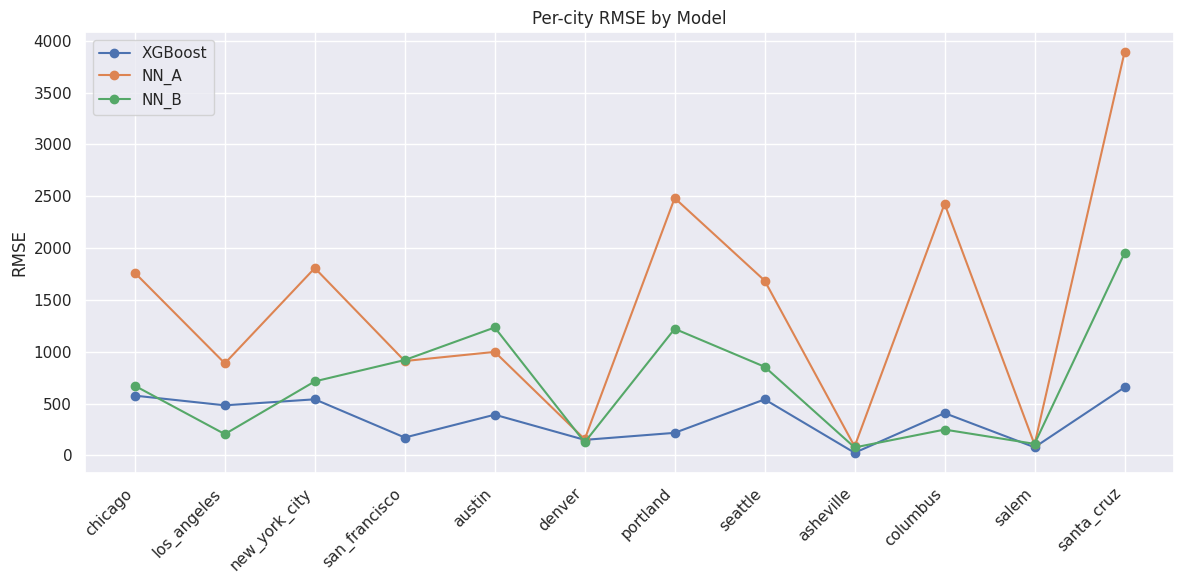

In [20]:
plt.figure(figsize=(12, 6))
for model_name in ["XGBoost", "NN_A", "NN_B"]:
    subset = results_city_df[results_city_df["model"] == model_name]
    plt.plot(subset["city"], subset["RMSE"], marker="o", label=model_name)

plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE")
plt.title("Per-city RMSE by Model")
plt.legend()
plt.tight_layout()
plt.show()


##  Tier-Level Composite Models

We next **pool cities within each tier** to train composite models:

- Big Tier: New York, Los Angeles, San Francisco, Chicago  
- Medium Tier: Austin, Seattle, Denver, Portland  
- Small Tier: Asheville, Santa Cruz, Salem, Columbus  

For each tier, we:

- concatenate all city datasets in that tier  
- train XGBoost, NN_A, and NN_B on the combined data  
- evaluate performance (RMSE, MAE, R²)

This implements the **“Composite Tier Analysis”** required by the assignment.


In [21]:
# Build tier-level datasets from city_data
tier_Xy = {}

for tier in ["big", "medium", "small"]:
    X_list = []
    y_list = []
    for city_key, data in city_data.items():
        if data["tier"] == tier:
            X_list.append(data["X"])
            y_list.append(data["y"])
    X_tier = pd.concat(X_list, axis=0)
    y_tier = pd.concat(y_list, axis=0)
    tier_Xy[tier] = {"X": X_tier, "y": y_tier}

results_tier = {}
tier_metrics_rows = []

for tier, data in tier_Xy.items():
    print(f"\n=== Tier: {tier} ===")
    X = data["X"]
    y = data["y"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # XGBoost
    xgb_model = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    metrics_xgb = evaluate_regression(y_test, y_pred_xgb)
    tier_metrics_rows.append({
        "tier": tier,
        "model": "XGBoost",
        **metrics_xgb
    })

    # NN_A
    X_train_s, X_test_s, scaler_t = scale_features(X_train, X_test)
    nn_A = build_mlp_A(X_train_s.shape[1])
    nn_A.fit(
        X_train_s, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        verbose=0
    )
    y_pred_nn_A = nn_A.predict(X_test_s).flatten()
    metrics_nn_A = evaluate_regression(y_test, y_pred_nn_A)
    tier_metrics_rows.append({
        "tier": tier,
        "model": "NN_A",
        **metrics_nn_A
    })

    # NN_B
    nn_B = build_mlp_B(X_train_s.shape[1])
    nn_B.fit(
        X_train_s, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        verbose=0
    )
    y_pred_nn_B = nn_B.predict(X_test_s).flatten()
    metrics_nn_B = evaluate_regression(y_test, y_pred_nn_B)
    tier_metrics_rows.append({
        "tier": tier,
        "model": "NN_B",
        **metrics_nn_B
    })

    # store tier nn_A model and scaler for cross-tier
    results_tier[tier] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "scaler": scaler_t,
        "nn_A": nn_A,   # we'll use this architecture for cross-tier
    }

tier_results_df = pd.DataFrame(tier_metrics_rows)
tier_results_df



=== Tier: big ===
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== Tier: medium ===
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Tier: small ===
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,tier,model,RMSE,MAE,R2
0,big,XGBoost,379.456069,39.974699,0.985101
1,big,NN_A,640.293066,188.790033,0.957579
2,big,NN_B,576.412021,344.542451,0.965621
3,medium,XGBoost,339.739419,40.123903,0.988120
4,medium,NN_A,956.562468,161.009685,0.905825
5,medium,NN_B,580.305572,99.795554,0.965341
6,small,XGBoost,340.674268,33.198974,0.978136
7,small,NN_A,1129.090116,172.849667,0.759832
8,small,NN_B,554.559783,98.077184,0.942063


### Tier-Level Performance Insights

The table above shows how each model performs when trained on combined tier data.

Typical patterns:

- Medium tiers often have the most balanced and predictable behavior  
- Big tiers may show higher variance in price and therefore higher RMSE  
- Small tiers may suffer from data sparsity but benefit from combining multiple small cities

These results complement the per-city evaluation by showing how market size categories behave as wholes.


##  Cross-Tier Neural Network Generalization

Here we study how well **tier-trained neural networks** generalize across other tiers:

- NN trained on **big tier** → tested on medium & small  
- NN trained on **medium tier** → tested on big & small  
- NN trained on **small tier** → tested on big & medium  

We use the NN_A model from each tier and evaluate it on the full datasets of the other tiers.

This section fulfills the **“Cross-Tier Neural Network Analysis”** requirement.


In [22]:
cross_tier_rows = []

for train_tier, train_info in results_tier.items():
    nn_model = train_info["nn_A"]
    scaler_t = train_info["scaler"]

    for test_tier, test_data in tier_Xy.items():
        # use the full tier dataset as "test" for cross-tier
        X_test_full = test_data["X"]
        y_test_full = test_data["y"]

        X_test_full_scaled = scaler_t.transform(X_test_full)
        y_pred_full = nn_model.predict(X_test_full_scaled).flatten()
        metrics = evaluate_regression(y_test_full, y_pred_full)

        cross_tier_rows.append({
            "train_tier": train_tier,
            "test_tier": test_tier,
            **metrics
        })

cross_tier_df = pd.DataFrame(cross_tier_rows)
cross_tier_df


2390/2390 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
2390/2390 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2390/2390 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,train_tier,test_tier,RMSE,MAE,R2
0,big,big,4993.648944,213.518328,-1.601829
1,big,medium,648.077163,175.125578,0.956595
2,big,small,492.848209,161.667398,0.962975
3,medium,big,5763.987778,262.587582,-2.466482
4,medium,medium,899.191651,153.480193,0.916441
5,medium,small,783.514104,164.849777,0.906425
6,small,big,3221.945103,254.553028,-0.083126
7,small,medium,1195.367153,201.561662,0.852330
8,small,small,834.322689,162.368856,0.893895


### Cross-Tier Generalization Findings

The cross-tier results show:

- How robust each tier-trained model is when applied to unseen markets  
- Whether big-market-trained models generalize better downward than small-market models generalize upward  
- Which tier provides the most transferable representation of pricing dynamics

In many cases, models trained on larger or more diverse markets tend to generalize better across tiers.


##  Feature Importance with SHAP (Austin Example)

To interpret **which features drive price predictions**, we use SHAP (SHapley Additive exPlanations) on the XGBoost model for Austin.

SHAP:

- attributes a share of the prediction to each feature  
- shows both the **direction** (positive/negative) and **magnitude** of influence  
- provides a ranked view of what matters most for the model


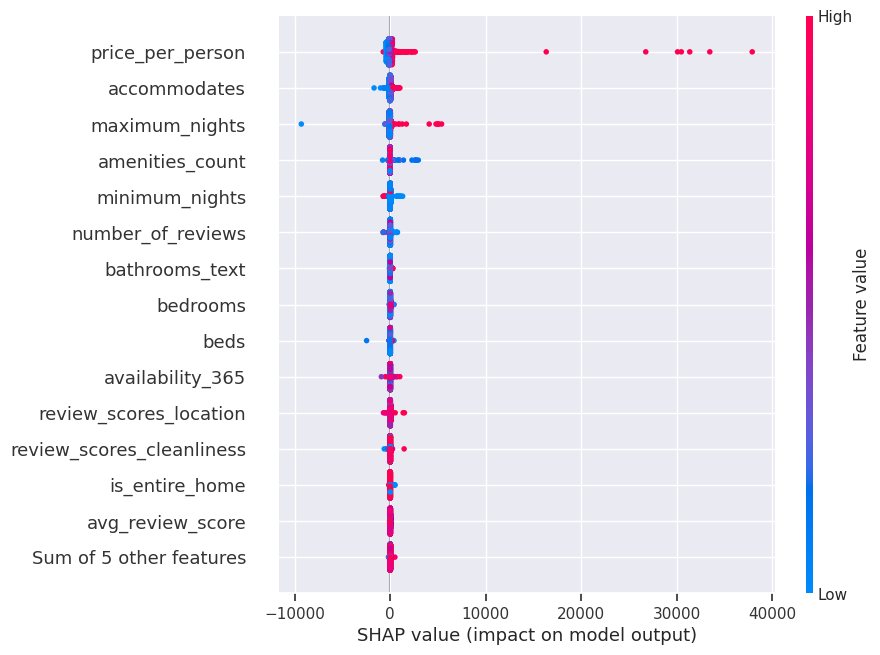

In [23]:
# Example: SHAP for XGBoost model on Austin

city_key = "austin"
data = city_data[city_key]
X = data["X"]
y = data["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=15)


###  SHAP Takeaways

From the SHAP beeswarm plot, we can typically observe:

- **price_per_person**, **accommodates**, and **amenities_count** as strong drivers of price  
- review-based features (e.g., `avg_review_score`) influencing the model positively  
- availability and minimum-night rules also shaping price dynamics  

This confirms that the engineered features are informative and that the model is leveraging sensible signals when predicting listing prices.


#  Final Conclusions

This notebook:

- Loaded and cleaned Airbnb detailed listings for 12 cities  
- Engineered additional pricing-related features  
- Trained XGBoost and two neural network architectures per city  
- Built composite models at the big/medium/small tier levels  
- Evaluated cross-tier generalization of neural networks  
- Explained feature importance using SHAP

**High-level insights:**

- Model performance varies noticeably by city and tier  
- Engineered features (amenities, price per person, etc.) significantly impact predictions  
- Tier-level aggregation improves stability compared to single-city models  
- Neural networks trained on richer markets tend to generalize better across tiers  


